# Statistical analysis - experiment 3

### Import the libraries 

In [1]:
import os
from tqdm import tqdm
import glob
import json
import numpy as np
import pandas as pd
import itertools
from csv import reader
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
from collections import Counter
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 

### Function to collect all csv-files in the folder

In [2]:
def list_csv_files(resultsdir):
    csv_files = []

    if os.path.isdir(resultsdir):
        for root, dirs, files in list(os.walk(resultsdir)):
            for name in files:
                subdir = root.split(resultsdir)
                all('' == s for s in subdir)
                
                if subdir[1].startswith('/'):
                    subdirname = subdir[1][1:]
                else:
                    subdirname = subdir[1]

                if name.lower().endswith('.csv'):
                    if all('' == s for s in subdir):
                        csv_files.append(name)
                    else:
                        csv_files.append(os.path.join(subdirname, name))
    
        csv_files.sort()

    return csv_files

### Load the csv-files and store the data in a pandas-dataframe 

In [3]:
resultsdir = "results/exp3"
writedir = "/mnt/nvme2n1p2/PieterBlok/PhD/Paper 04 - Active Learning/Results/exp3"

two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
resultsdir = os.path.join(two_up, resultsdir)
csv_files = list_csv_files(resultsdir)

clmns = ["sampling_method", "run", "number_images", "mAP", "mAP_healthy", "mAP_damaged", "mAP_matured", "mAP_cateye", "mAP_headrot"]
df = pd.DataFrame(columns=clmns)

for c in range(len(csv_files)):
    csv_file = csv_files[c]
    splits = csv_file.split("/")
    run_no = splits[0].split("run")[-1]
    sam_mt = splits[1].split("_")[0]
    
    if sam_mt == 'random':
        sam_mt = 'random sampling'
        
    if sam_mt == 'uncertainty':
        sam_mt = 'active learning'

    with open(os.path.join(resultsdir, csv_file), 'r') as read_obj:
        csv_reader = reader(read_obj)
        next(csv_reader)
        for row in csv_reader:
            data = [sam_mt, int(run_no), int(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5]), float(row[6])]
            df.loc[len(df)] = data
            
df

,sampling_method,run,number_images,mAP,mAP_healthy,mAP_damaged,mAP_matured,mAP_cateye,mAP_headrot
0,random sampling,1,100,22.1,58.0,19.0,21.9,10.3,1.4
1,random sampling,1,300,35.1,64.9,35.9,44.1,16.6,13.8
2,random sampling,1,500,36.9,67.6,30.9,49.7,16.2,19.9
3,random sampling,1,700,40.7,62.8,33.3,47.7,29.9,29.9
4,random sampling,1,900,45.2,71.4,42.1,58.3,28.7,25.4
...,...,...,...,...,...,...,...,...,...
125,active learning,4,1700,55.8,69.1,57.9,69.5,42.8,39.8
126,active learning,4,1900,57.3,72.8,59.5,68.3,39.7,46.0
127,active learning,4,2100,57.3,72.8,59.5,68.3,39.7,46.0
128,active learning,4,2300,57.3,72.8,59.5,68.3,39.7,46.0


In [4]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/interactions_anova.html#Two-way-ANOVA
# https://www.statology.org/fishers-least-significant-difference/
# https://personal.utdallas.edu/~herve/abdi-LSD2010-pretty.pdf
# https://stackoverflow.com/questions/19339305/python-function-to-get-the-t-statistic
# https://www.youtube.com/watch?v=ZRX4lFtMboo

num_img = df["number_images"].values.ravel()
num_img = pd.unique(num_img)
runs = df["run"].values.ravel()
runs = pd.unique(runs)

for ni in range(len(num_img)):
    cur_num_img = num_img[ni]
    sel = df[df["number_images"] == cur_num_img]
    print("Number of sampled images: {:d}\n".format(cur_num_img))
    mean = sel.groupby(['sampling_method']).mean()
    mean_map = sel.groupby(['sampling_method']).mean()['mAP']
    diff = mean_map['active learning'] - mean_map['random sampling']
    print(mean.round(1))
    print("Difference: {:.1f}".format(diff))

    nosum_lm = ols("mAP ~ C(sampling_method)", data=sel).fit()
    an = anova_lm(nosum_lm)
    print(an)

    t = stats.t.ppf(1-0.025, an.df.Residual)
    LSD = t * np.sqrt(an.mean_sq.Residual * (1/len(runs) + 1/len(runs)))
    print("Least Significant Difference: {:.2f}".format(LSD))

Number of sampled images: 100

                  mAP  mAP_healthy  mAP_damaged  mAP_matured  mAP_cateye  \
sampling_method                                                            
active learning  20.7         57.3         14.4         22.1         4.1   
random sampling  20.7         57.3         14.4         22.1         4.1   

                 mAP_headrot  
sampling_method               
active learning          5.7  
random sampling          5.7  
Difference: 0.0
                     df        sum_sq       mean_sq             F  PR(>F)
C(sampling_method)  1.0  5.048710e-29  5.048710e-29  8.557135e-30     1.0
Residual            8.0  4.720000e+01  5.900000e+00           NaN     NaN
Least Significant Difference: 3.54
Number of sampled images: 300

                  mAP  mAP_healthy  mAP_damaged  mAP_matured  mAP_cateye  \
sampling_method                                                            
active learning  33.9         65.7         25.3         56.8        11.5   
random s

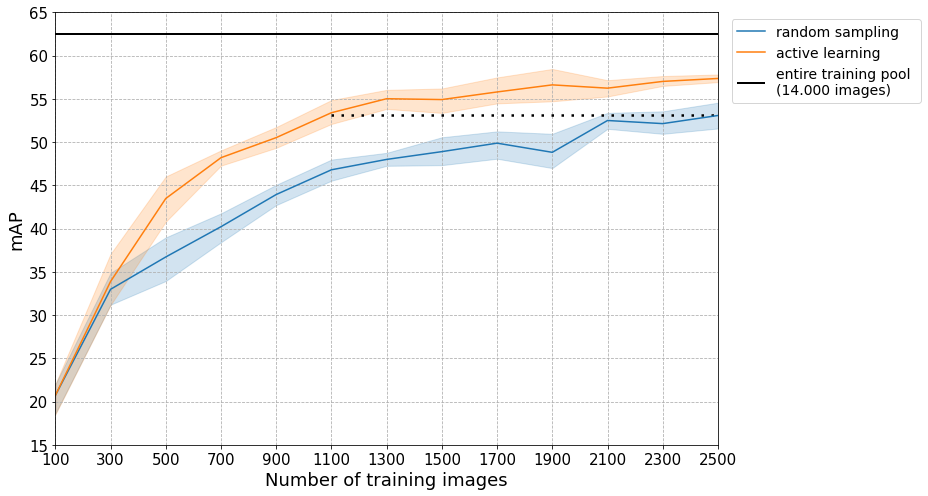

In [5]:
font_size = 18
digit_size = 15
annot_size = 14
pool_size = 200
sign_letters_al = ['', '', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
sign_letters_rs = ['', '', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

f, ax = plt.subplots(figsize=(13, 7))
ax = sns.lineplot(data=df, x="number_images", y="mAP", hue="sampling_method", ci=95, markers=True, palette = "tab10")
plt.hlines(62.5, df['number_images'].min(), df['number_images'].max(), colors='k', linewidth=2, linestyles='solid', label='entire training pool \n(14.000 images)')
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left", fontsize=annot_size)

ax.set_xlim([100,2500])
ax.set_yticks(np.arange(15, 70, 5))
ax.set_ylim([15,65])
ax.grid(which='major', axis='x', linestyle='--')
ax.grid(which='major', axis='y', linestyle='--')

plt.xlabel('Number of training images', fontsize=font_size)
plt.xticks(range(df['number_images'].min(), df['number_images'].max()+pool_size, pool_size), fontsize=digit_size)
plt.ylabel('mAP', fontsize=font_size)
plt.yticks(fontsize=digit_size)

line_values = df.groupby(['number_images', 'sampling_method'])['mAP'].mean()
last_value_random = line_values.loc[df['number_images'].max()]['random sampling']
line1 = ax.lines[1]
line1.get_ydata()
plt.hlines(last_value_random, 1100, df['number_images'].max(), colors='k', linewidth=2.5, linestyles=(0, (1, 3)))

# for ni in range(len(num_img)):
#     cur_num_img = num_img[ni]
#     sel = df[df["number_images"] == cur_num_img]
#     mean_map = sel.groupby(['sampling_method']).mean()['mAP']
#     al_map = mean_map['active learning'] 
#     rs_map = mean_map['random sampling']
    
#     plt.annotate(sign_letters_al[ni], (cur_num_img-20, al_map+1), fontsize=annot_size)
#     plt.annotate(sign_letters_rs[ni], (cur_num_img-20, rs_map+1), fontsize=annot_size)

plt.tight_layout()
plt.savefig(os.path.join(writedir, "mAP_active_learning.png"))
plt.show()

## Certainty values

In [6]:
sampling_size = 200
subfolders = []

for path, subdirs, files in os.walk(resultsdir):
    for name in files:
        if os.path.splitext(name)[-1] == ".txt" and "trainfiles_iteration" in os.path.splitext(name)[0]:
            if path not in subfolders:
                subfolders.append(path)

clmns = ["sampling_method", "run", "number_images", "image_name", "certainty_value"]
df2 = pd.DataFrame(columns=clmns)
txtfiles = []

for p in range(len(subfolders)):
    subfolder = subfolders[p]
    txtfiles = glob.glob(subfolder + "/*.txt")
    txtfiles.sort()

    run_no = int(subfolder.split("/")[-2][-1])
    sam_mt = subfolder.split("/")[-1]
    
    if sam_mt == 'random':
        sam_mt = 'random sampling'
        
    if sam_mt == 'uncertainty':
        sam_mt = 'active learning'

    sam_freq = 2400 / sampling_size
    start_img_num = 100

    for tf in range(len(txtfiles)):
        txtfile = txtfiles[tf]
        it_num = int(os.path.splitext(os.path.basename(txtfile))[0][-3:])
        img_num = start_img_num + (sampling_size*it_num)
        
        df3 = pd.read_csv(txtfile, names=["image_name", "certainty_value"])
        df3['certainty_value'] = pd.to_numeric(df3['certainty_value'], errors='coerce')
        if it_num != 0:
            df3 = df3[df3['certainty_value'].notna()]
        df3.insert(loc=0, column='number_images', value=img_num)
        df3.insert(loc=0, column='run', value=run_no)
        df3.insert(loc=0, column='sampling_method', value=sam_mt)

        df2 = df2.append(df3, ignore_index=True)
df2

,sampling_method,run,number_images,image_name,certainty_value
0,random sampling,1,100,field03_santa_maria/RealSense_20191103_002542_...,NaN
1,random sampling,1,100,field24_sexbierum/20200713_160337832338_plant1...,NaN
2,random sampling,1,100,field25_sexbierum/20200819_170454781697_plant1...,NaN
3,random sampling,1,100,field07_burlington/20180807_103132116_RGB.jpg,NaN
4,random sampling,1,100,field07_burlington/20180807_112733216_RGB.jpg,NaN
...,...,...,...,...,...
24995,active learning,2,2500,field07_burlington/20180813_155948766_RGB.jpg,0.831083
24996,active learning,2,2500,field19_sexbierum/20160930_111509.jpg,0.831482
24997,active learning,2,2500,field02_santa_maria/165_Untrimmed_Frame_9_157_...,0.832071
24998,active learning,2,2500,field25_sexbierum/20200819_140346386905_plant1...,0.832199


### Pooled class instances

In [7]:
supported_cv2_formats = (".bmp", ".dib", ".jpeg", ".jpg", ".jpe", ".jp2", ".png", ".pbm", ".pgm", ".ppm", ".sr", ".ras", ".tiff", ".tif")


def check_direxcist(dir):
    if dir is not None:
        if not os.path.exists(dir):
            os.makedirs(dir)  # make new folder


def find_valid_images_and_annotations(rootdir):
    image_annotation_pairs = []

    for root, dirs, files in tqdm(list(os.walk(rootdir))):
        for name in files:
            if name.endswith((".json")):
                full_path = os.path.join(root, name)
                with open(full_path, 'r') as json_file:
                    try:
                        data = json.load(json_file)

                        ## labelme
                        if 'version' in data:
                            annot_format = 'labelme'
                            if 'shapes' in data:
                                if len(data['shapes']) > 0:
                                    imgname = data['imagePath']
                                    imgpath = os.path.join(root, imgname)

                                    if os.path.exists(imgpath):
                                        image_annotation_pairs.append([os.path.basename(root), imgpath, full_path, annot_format])

                    except:
                        continue

    return image_annotation_pairs


def process_labelme_json(jsonfile, classnames):
    group_ids = []

    with open(jsonfile, 'r') as json_file:
        data = json.load(json_file)
        for p in data['shapes']:
            group_ids.append(p['group_id'])

    only_group_ids = [x for x in group_ids if x is not None]
    unique_group_ids = list(set(only_group_ids))
    no_group_ids = sum(x is None for x in group_ids)
    total_masks = len(unique_group_ids) + no_group_ids

    all_unique_masks = np.zeros(total_masks, dtype = object)

    if len(unique_group_ids) > 0:
        unique_group_ids.sort()

        for k in range(len(unique_group_ids)):
            unique_group_id = unique_group_ids[k]
            all_unique_masks[k] = unique_group_id

        for h in range(no_group_ids):
            all_unique_masks[len(unique_group_ids) + h] = "None" + str(h+1)
    else:
        for h in range(no_group_ids):
            all_unique_masks[h] = "None" + str(h+1)    

    category_ids = []
    masks = []
    crowd_ids = []

    for i in range(total_masks):
        category_ids.append([])
        masks.append([])
        crowd_ids.append([])

    none_counter = 0 

    for p in data['shapes']:
        group_id = p['group_id']

        if group_id is None:
            none_counter = none_counter + 1
            fill_id = int(np.where(np.asarray(all_unique_masks) == (str(group_id) + str(none_counter)))[0][0])
        else:
            fill_id = int(np.where(np.asarray(all_unique_masks) == group_id)[0][0])

        classname = p['label']

        try:
            category_ids[fill_id] = classname
            run_further = True
        except:
            print("Cannot find the class name (please check the annotation files)")
            run_further = False

        if run_further:
            if p['shape_type'] == "circle":
                # https://github.com/wkentaro/labelme/issues/537
                bearing_angles = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 
                180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360]
                            
                orig_x1 = p['points'][0][0]
                orig_y1 = p['points'][0][1]

                orig_x2 = p['points'][1][0]
                orig_y2 = p['points'][1][1]

                cx = (orig_x2 - orig_x1)**2
                cy = (orig_y2 - orig_y1)**2
                radius = math.sqrt(cx + cy)

                circle_polygon = []
            
                for k in range(0, len(bearing_angles) - 1):
                    ad1 = math.radians(bearing_angles[k])
                    x1 = radius * math.cos(ad1)
                    y1 = radius * math.sin(ad1)
                    circle_polygon.append( (orig_x1 + x1, orig_y1 + y1) )

                    ad2 = math.radians(bearing_angles[k+1])
                    x2 = radius * math.cos(ad2)  
                    y2 = radius * math.sin(ad2)
                    circle_polygon.append( (orig_x1 + x2, orig_y1 + y2) )

                pts = np.asarray(circle_polygon).astype(np.float32)
                pts = pts.reshape((-1,1,2))
                points = np.asarray(pts).flatten().tolist()
                
            if p['shape_type'] == "rectangle":
                (x1, y1), (x2, y2) = p['points']
                x1, x2 = sorted([x1, x2])
                y1, y2 = sorted([y1, y2])
                points = [x1, y1, x2, y1, x2, y2, x1, y2]

            if p['shape_type'] == "polygon":
                points = p['points']
                pts = np.asarray(points).astype(np.float32).reshape(-1,1,2)   
                points = np.asarray(pts).flatten().tolist()

            masks[fill_id].append(points)

            ## labelme version 4.5.6 does not have a crowd_id, so fill it with zeros
            crowd_ids[fill_id] = 0
            status = "successful"
        else:
            status = "unsuccessful"

    return category_ids, masks, crowd_ids, status

Sampling method: active learning


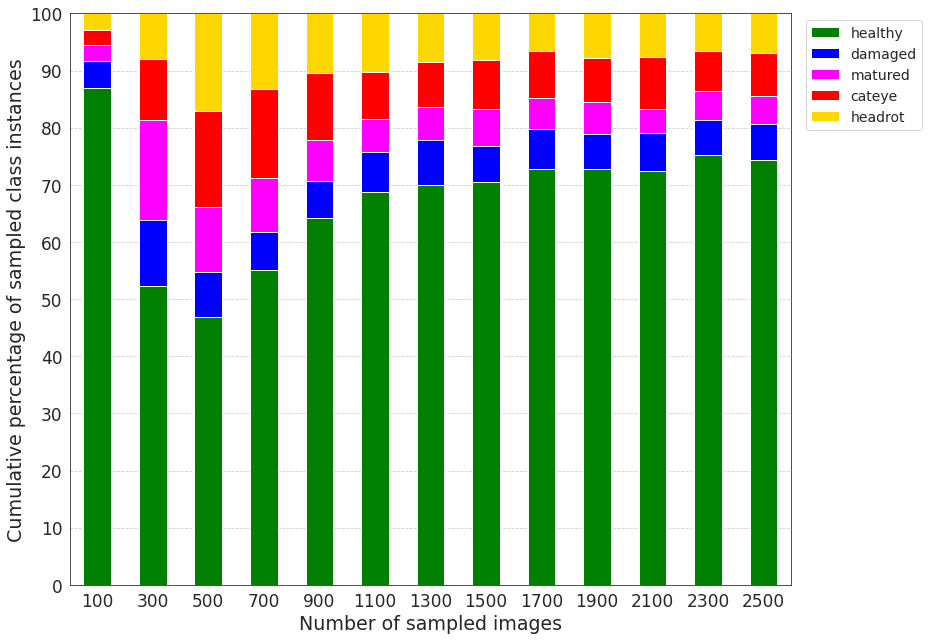

Sampling method: random sampling


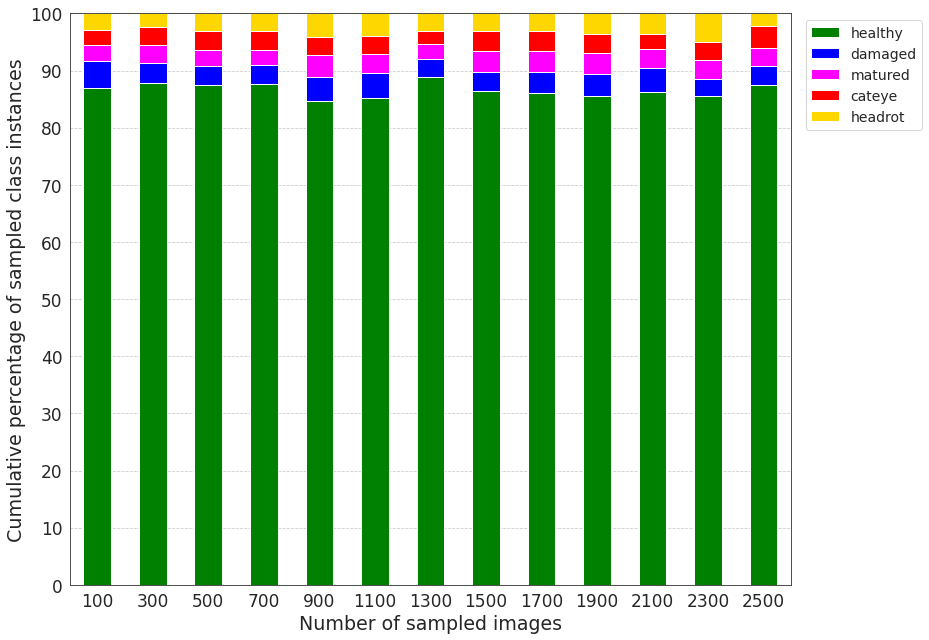

In [8]:
imgdir = "/mnt/nvme2n1p2/PieterBlok/PhD/Paper 04 - Active Learning/Data/train"
font_size = 19
digit_size = 17
annot_size = 14

classes = ['healthy', 'damaged', 'matured', 'cateye', 'headrot']
class_names = ['healthy_total', 'damaged_total', 'matured_total', 'cateye_total', 'headrot_total']
header = class_names.copy()
header.insert(0, 'iteration')
header.insert(1, 'train size')
iters = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
color={"healthy": "green", "damaged": "blue", "matured": "magenta", "cateye": "red", "headrot": "gold"}

samp_mt = df2["sampling_method"].values.ravel()
samp_mt = pd.unique(samp_mt)
samp_mt.sort()

for sf in range(len(samp_mt)):
    data_combined = []
    cur_samp_mt = samp_mt[sf]
    sel = df2[df2["sampling_method"] == cur_samp_mt]
    print("Sampling method: {:s}".format(cur_samp_mt))

    for ni in range(len(num_img)):
        class_categories = []
        iter = iters[ni]
        if ni == 0:
            sel_ni = sel[sel["number_images"] == num_img[ni]]
            cur_num_img = num_img[ni]
        else:
            prev_num_img = num_img[ni-1]
            cur_num_img = num_img[ni]
            sel_ni = sel[sel['number_images'].between(prev_num_img+1, cur_num_img)]
            
        image_names = sel_ni['image_name'].tolist()

        for im in range(len(image_names)):
            img_name = image_names[im]
            basename = os.path.splitext(img_name)[0]
            annot_name = basename + ".json"
            annot_file = os.path.join(imgdir, annot_name)

            if os.path.exists(annot_file):
                categories, masks, crowd_ids, status = process_labelme_json(annot_file, classes)

                for c in range(len(categories)):
                    category = categories[c]
                    class_categories.append(category)
                    
        ucc = list(Counter(class_categories).keys())
        vcc = list(Counter(class_categories).values())
        count_list = np.zeros(len(classes)).astype(np.int16)

        for b in range(len(classes)):
            _class = classes[b]
            idx = ucc.index(_class)
            count_list[b] = vcc[idx]
            
        data_to_merge = list(count_list)
        data_to_merge.insert(0, iter)
        data_to_merge.insert(1, cur_num_img)
        data_combined.append(data_to_merge)

    df4 = pd.DataFrame(data=data_combined, columns=header)
    df4.sort_values(by=['iteration'], ignore_index=True, inplace=True)
    pool_size = df4['train size'][1] - df4['train size'][0]

    cum_values = []
    total = df4.copy()
    total['sum'] = df4.loc[:, class_names[0]:class_names[-1]].sum(axis=1)
    total.drop(columns=class_names)

    for c in range(len(classes)):
        _class = classes[c]
        class_name = class_names[c]
        total[_class] = (df4.loc[:][class_name] / total['sum']) * 100

    sns.set_style("whitegrid")
    sns.set_style("white")
    df5 = total.loc[:, classes[0]:classes[-1]]
    ax = df5.plot.bar(stacked=True, figsize=(13, 9), color=color)
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_ylim([0, 100])
    
    plt.subplots_adjust(right=0.85)
    plt.legend(bbox_to_anchor=(1.01,1), loc="upper left", fontsize=annot_size)
    plt.xlabel('Number of sampled images', fontsize=font_size)
    plt.xticks(range(0, df4['iteration'].max()+1), range(df4['train size'][0], df4['train size'].max()+pool_size, pool_size), fontsize=digit_size, rotation='horizontal')
    plt.ylabel('Cumulative percentage of sampled class instances', fontsize=font_size)
    plt.yticks(np.arange(0, 110, 10), fontsize=digit_size)

    plt.tight_layout()
    write_name = "class_instances_{:s}.png".format(cur_samp_mt)
    plt.savefig(os.path.join(writedir, write_name))
    plt.show()